In [15]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('../utils')
import models
from scipy.stats import norm

sns.set(style="whitegrid")

In [16]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

In [17]:
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

In [18]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [19]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [20]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

In [75]:
df = pd.read_csv('../datasets/airbnb_selected_variables.csv', index_col=0)

Freeman Diaconis:  11


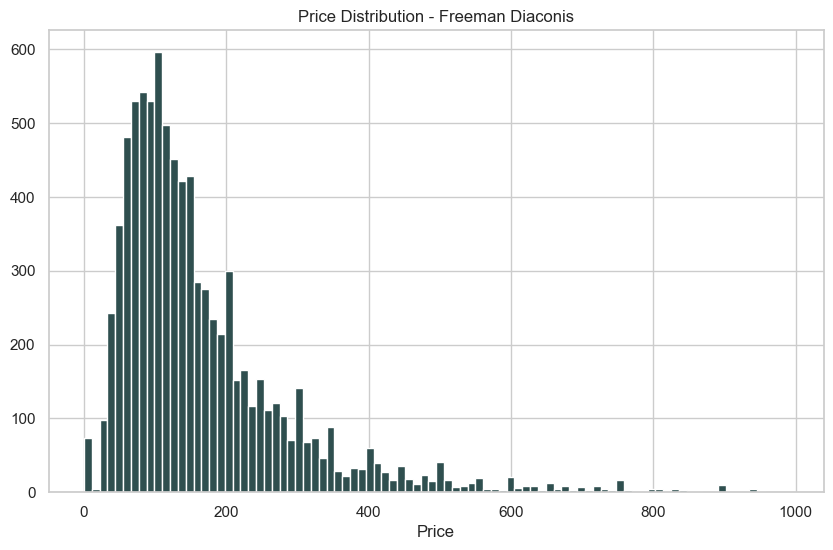

In [76]:
h = freeman_diaconis(df.price)
print("Freeman Diaconis: ", h)
mn = int(df.price.min())
mx = int(df.price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.price,bins=bins, color="darkslategray")
axes.set_title("Price Distribution - Freeman Diaconis")
axes.set_xlabel("Price")

plt.show()
plt.close()

Freeman Diaconis:  11


Text(0.5, 0, 'Price')

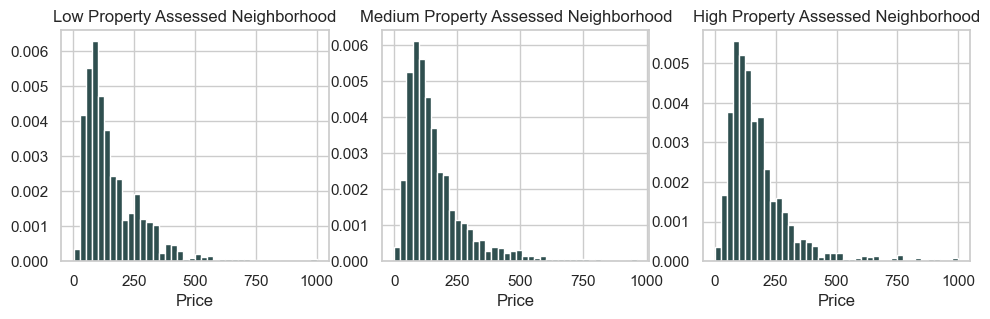

In [85]:
h = freeman_diaconis(df.price)
print("Freeman Diaconis: ", h)
mn = int(df.price.min())
mx = int(df.price.max())
bins = [i for i in range( mn, mx, h)]
grouped = df.groupby("neighborhood_label")

figure = plt.figure(figsize=(20, 3))

axes = figure.add_subplot(1, 5, 1)
axes.hist(grouped["price"].get_group('low'),bins=40,color="darkslategray",density=True)
axes.set_title("Low Property Assessed Neighborhood")
axes.set_xlabel("Price")


axes = figure.add_subplot(1, 5, 2)
axes.hist(grouped["price"].get_group('medium'),bins=40,color="darkslategray",density=True)
axes.set_title("Medium Property Assessed Neighborhood")
axes.set_xlabel("Price")


axes = figure.add_subplot(1, 5, 3)
axes.hist(grouped["price"].get_group('high'),bins=40,color="darkslategray",density=True)
axes.set_title("High Property Assessed Neighborhood")
axes.set_xlabel("Price")


In [86]:
df.room_type = df.room_type.map({'Private room': 'private_room',
                                'Entire home/apt': 'entire_property',
                                'Shared room': 'shared_room'})

df.host_response_time = df.host_response_time.map({'within an hour': 'lt_hour',
                                                 'within a few hours': 'lt_few_hours',
                                                 'within a day': 'lt_day',
                                                 'a few days or more': 'gt_day'})

In [87]:
dummy_var_list = ['host_is_superhost', 'room_type', 'property_type', 'instant_bookable',
                 'neighborhood_label', 'bathroom_type', 'host_response_time']
for v in dummy_var_list:
    df = pd.concat([df, pd.get_dummies(df[v], prefix=v)], axis=1)
    df = df.drop(v, axis=1)

In [88]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [89]:
feature_list = df.columns[df.columns!='price']
correlations(df, 'price', feature_list)

,feature,r,rho
0,bedrooms,0.391956,0.415564
1,beds,0.421871,0.456713
2,accommodates,0.508050,0.553506
3,host_response_rate,0.023571,0.034322
4,host_acceptance_rate,0.102784,0.142665
5,number_of_reviews,-0.051700,-0.035164
6,review_scores_rating,-0.052113,0.003706
7,reviews_per_month,0.000882,0.011596
8,num_baths,0.472966,0.461407
9,host_is_superhost_f,-0.045080,-0.062989


### Results
Variables to use:
- bedrooms
- beds
- accommodates
- num_baths
- room_type (Entire home/apt, Private room, Shared room)
- property_type
- neighborhood
- bathroom
- host_response_time

In [90]:
model1 = f'''price ~'''
for f in feature_list: 
    model1+= f''' {f} +'''
model1 = model1.rstrip(' +')
result1 = models.bootstrap_linear_regression(model1, data=df)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-2797810875944.62,-3872313714788.92,6588727320987.99
bedrooms,$\beta_{1}$,12.40,8.34,15.39
beds,$\beta_{2}$,-4.21,-8.80,1.69
accommodates,$\beta_{3}$,14.38,10.35,17.55
host_response_rate,$\beta_{4}$,-0.10,-0.21,-0.02
host_acceptance_rate,$\beta_{5}$,0.19,0.08,0.31
number_of_reviews,$\beta_{6}$,-0.06,-0.10,-0.02
review_scores_rating,$\beta_{7}$,-5.63,-7.36,-4.19
reviews_per_month,$\beta_{8}$,-0.19,-4.11,3.67


In [136]:
df['br_sq'] = df['bedroom']**2

KeyError: 'bedroom'

In [135]:
model2='''price ~ 
accommodates +
num_baths + 
bedrooms +
beds +
review_scores_rating'''
result2 = models.bootstrap_linear_regression(model2, data=df)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,58.87,49.08,71.03
accommodates,$\beta_{1}$,21.64,18.80,25.26
num_baths,$\beta_{2}$,42.88,30.75,52.49
bedrooms,$\beta_{3}$,0.57,-2.13,4.05
beds,$\beta_{4}$,-4.14,-9.13,0.68
review_scores_rating,$\beta_{5}$,-5.90,-7.23,-4.89
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,109.52,105.29,113.89,


In [132]:
def plot_residuals(df, result, variables):
    figure = plt.figure(figsize=(20,6))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(df[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

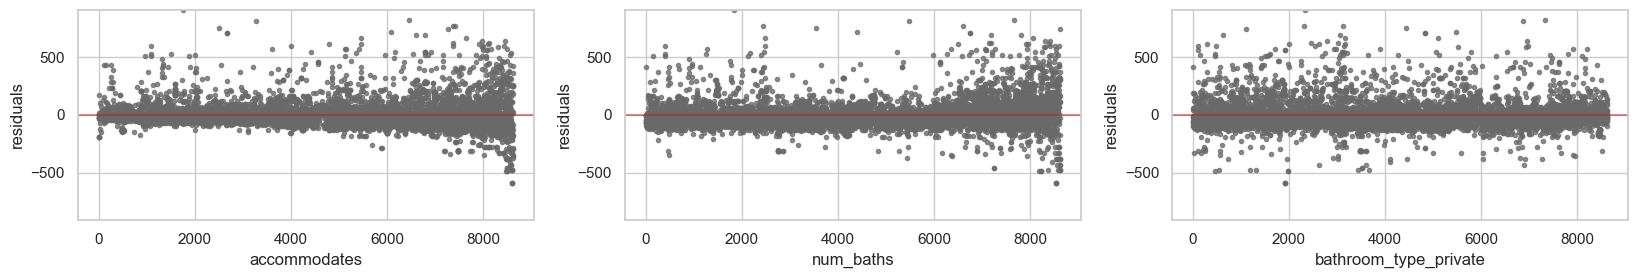

array([-72.22070312, -96.56640625,  38.7890625 , ..., -87.2109375 ,
        22.62890625, -32.2109375 ])

In [133]:
variables = ["accommodates", "num_baths", "bathroom_type_private"]
plot_residuals(df, result2, variables)